# Прогнозироване зарплаты по описанию вакансии

Будем предсказывать зарплату по описанию вакансии - это задача регрессии!

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [2]:
# зафиксируем random state для воспроизводимости результатов
RANDOM_STATE = 42

In [3]:
#  Прочитаем файл salary_data.csv
try:
    df = pd.read_csv('salary_data.csv', index_col = [0])
except:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/salary_data.csv', index_col = [0])



Mounted at /content/drive


In [4]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,hourly,employer_provided,min_salary,max_salary,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEducation Required: Bachelor’s degree required, prefe...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,0,0,53,91,72.0,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe Healthcare Data Scientist position will join our ...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,0,0,63,112,87.5,University of Maryland Medical System\n,MD,0,36,1,0,0,0,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information security company. We are the world's largest provider...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,0,0,80,90,85.0,KnowBe4\n,FL,1,10,1,0,1,0,1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\nDirectorate: Earth & Biological Sciences\n\nDivisi...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewable Energy Lab, Los Alamos National Laboratory",0,0,56,97,76.5,PNNL\n,WA,1,55,1,0,0,0,0
4,Data Scientist,$86K-$143K (Glassdoor est.),"Data Scientist\nAffinity Solutions / Marketing Cloud seeks smart, curious, technically savvy can...",2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0,86,143,114.5,Affinity Solutions\n,NY,1,22,1,0,0,0,1


Посмотрим на распределение целевой переменной. Построим гистограмму распределения вероятностей признака `avg_salary`

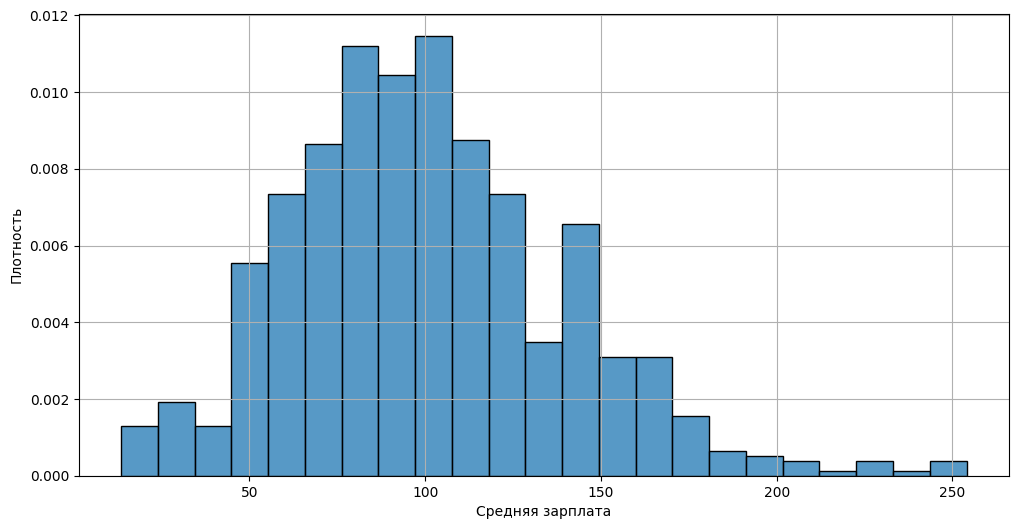

In [9]:
plt.figure(figsize=(12, 6))
sns.histplot(df['avg_salary'], stat = 'density')
plt.grid()
plt.xlabel('Средняя зарплата')
plt.ylabel('Плотность')
plt.show()

Распределение похоже на нормальное. Наблюдаем небольшой "хвост" справа. Лучший вариант для линейной регрессии.

Найдем средние/медианные зарплаты в зависимости от профессии. Используем метод `groupby()`

In [10]:
df.groupby('Job Title')['avg_salary'].median()

,avg_salary
Job Title,
Ag Data Scientist,80.5
Analytics - Business Assurance Data Analyst,43.0
Analytics Consultant,66.5
Analytics Manager,87.5
Analytics Manager - Data Mart,64.0
...,...
System and Data Analyst,59.0
Systems Engineer II - Data Analyst,62.5
"Technology-Minded, Data Professional Opportunities",70.5


Медианные зарплаты для разных профессий отличаются.


In [11]:
# Посмотрим, сколько разных профессий присутствует в вакансиях
df['Job Title'].nunique()

264

Разобъем данные на тренировочные и тестовые в пропорции 80:20. Для базового решения обучения будем использовать в качестве признаков только описание вакансии `Job Description`

In [13]:
X = df['Job Description']
y = df['avg_salary']

In [15]:

%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, X_test.shape

CPU times: user 3.94 ms, sys: 0 ns, total: 3.94 ms
Wall time: 11.5 ms


((593,), (149,))

## Задание 1.
Закодируйте столбец `Job Description` при помощи **tf-idf**:

* обучите (метод `fit`) на тренировочных данных `X_train`, а затем примените (`transform`) и к трейну, и к тесту в отдельности.

*  попробуйте подобрать гиперпараметры `min_df`, `max_df`,  `ngram_range` у метода **tf-idf** для достижения наилучшего качества модели

In [ ]:
# ваш код здесь
...

**Вопрос:** если использовать `min_df = 5`, `max_df=1.0`, `ngram_range=(1,1)`, то сколько столбцов получится в матрице признаков после применения кодировки?

**Напишите свой ответ здесь**


Обучите линейную регрессию на тренировочных данных и сделайте предсказания на тренировочных и тестовых данных. Для улучшения качества модели проведите регуляризацию линейной модели (Ridge или Lasso). Какой параметр регуляризации Вы выбрали и почему?

In [ ]:
# ваш код здесь
...

Посчитаем метрику качества предсказания $R^2$. Чем ближе она к 1, тем лучше качество модели.

Посчитайте значение $R^2$ на тренировочных и на тестовых данных.

**Вопрос:** чему равен $R^2$ на трейне и на тесте?

In [ ]:
# ваш код здесь
...

Потестируйте построенную модель. Посмотрите, как она прогнозирует зарплаты для разных вакансий

In [ ]:
model.predict(tfidf.transform([u"director"]))

In [ ]:
model.predict(tfidf.transform([u"manager"]))

**Вопрос:** посчитайте зарплату "data scientist" при помощи модели.

In [ ]:
# ваш код здесь
...

Посмотрим на веса модели.


In [ ]:
%%time
coefs = sorted(zip(list(np.array(tfidf.get_feature_names())[model.coef_ != 0]), model.coef_[model.coef_ != 0]),
               key=lambda x: -x[1])
coefs = pd.DataFrame(coefs, columns=["ngram", "weight"])

Выведите на экран весовые коэффициенты построенной модели и постройте график (столбиковую диаграмму) весовых коэффициентов. Укажите, какие "признаки" наиболее важные для построенной модели.

**Вопрос:** какой признак имеет наибольший положительный вес?


In [ ]:
# ваш код здесь
...

## Задание 2
Закодируйте столбец `Job Description` при помощи мешка слов (`CountVectorizer()`).

Постройте модель линейной регрессии на тренировочных данных и сделайте предсказания на тренировочных и тестовых данных.

Рассчитайте метрику качества предсказания $R^2$ на тренировочных и на тестовых данных.

Потестируйте построенную модель. Посмотрите, как она прогнозирует зарплаты для разных вакансий. Сделайте прогноз зарплаты для "data scientist" при помощи построенной модели.

**Вопрос:** Как изменилось качество модели? чему равен $R^2$ на тесте? какой признак имеет наибольший положительный вес?

In [ ]:
# ваш код здесь
...

## Задание 3

Добавьте в модель другие признаки (например, рейтинг компании, численность сотрудников, сферу деятельности компании, требуемые навыки для кандидата или другие). Как изменилось качество прогноза? Какие признаки имеют наибольший вес?

In [ ]:
# ваш код здесь
...

## Сформулируйте выводы по работе.

Сравните полученные решения, выберите "лучшую" модель. Какие признаки оказались важными для прогноза заработной платы?